# Sibship clustering

Tom Ellis, March 2017

FAPS uses information in a `paternityArray` to generate plausible full-sibship configurations. This information is stored as a `sibshipCluster` object, and is the basis for almost all inference about biological processes in FAPS.

This notebook will examine how to:

1. Use a `paternityArray` to cluster offspring into plausible full-sibships.
2. Compare the relative support for different partitions structures
3. Make some basic inferences about the size and number of full sibships, and who is related to whom.

If the goal of your study is to say something about how specific phenotypes or geography influence patterns of mating, you can then use your `sibshipArray` to [sample likely mating events](https://github.com/ellisztamas/faps/blob/master/docs/05%20Inference%20about%20mating%20patterns.ipynb), accounting fo uncertainty in sibship structure.

## Generating a `sibshipCluster` object

We will begin by generating a population of 100 adults with 50 loci.

In [1]:
from faps import *
import numpy as np

np.random.seed(867)
allele_freqs = np.random.uniform(0.3,0.5,50)
adults = make_parents(100, allele_freqs, family_name='a')

We take the first individal as the mother and mate her to four males, to create four full sibships of five offspring. We then generate a `paternityArray` based on the genotype data.

In [4]:
progeny = make_sibships(adults, 0, [1,2,3,4], 5, 'x')
mothers = adults.subset(progeny.parent_index('m', adults.names))
patlik  = paternity_array(progeny, mothers, adults, adults.allele_freqs(), mu = 0.0015)

It is straightforward to cluster offspring into full sibships. For now we'll stick with the default number of Monte Carlo draws.

In [6]:
sc = sibship_clustering(patlik, MC_draws=1000)

Sibship clustering calculates likelihoods that each pair of offspring are full siblings, then builds a dendrogram from this. We can visualise this dendrogram if we so wish, although the output is not pretty.

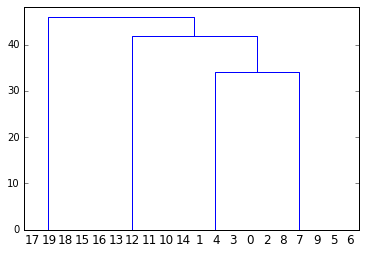

In [7]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

dendrogram(sc.linkage_matrix)
plt.show()

Offspring individuals are labelled by their *index* in the array. Since full sibships are of size five we should expect to see clusters of {0,1,2,3,4}, {5,6,7,8,9}, {10,11,12,13,14} and {15,16,17,18,19}. This is indeed what we do see. What is difficult to see on the dendrogram are the branches connecting full siblings at the very bottom of the plot. If we bisect this dendrogram at different places on the y-axis we can infer different ways to partition the offspring into full siblings.

`sc` is an object of class `sibshipCluster` that contains various information about the array. Of primary interest are the set of partition structures inferred from the dendrogram. In this case there are eight unique partitions.

In [8]:
sc.partitions

array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,
         1,  1,  1],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  2,  2,  2,  1,  1,
         1,  1,  1],
       [ 3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  2,  2,  2,  2,  2,  1,  1,
         1,  1,  1],
       [ 3,  3,  3,  3,  3,  4,  4,  4,  5,  4,  2,  2,  2,  2,  2,  1,  1,
         1,  1,  1],
       [ 3,  3,  3,  3,  3,  4,  4,  5,  6,  4,  2,  2,  2,  2,  2,  1,  1,
         1,  1,  1],
       [ 3,  4,  3,  3,  3,  5,  5,  6,  7,  5,  2,  2,  2,  2,  2,  1,  1,
         1,  1,  1],
       [ 4,  5,  4,  4,  4,  6,  6,  7,  8,  6,  3,  3,  3,  3,  3,  1,  1,
         2,  1,  1],
       [ 4,  5,  4,  4,  4,  6,  6,  8,  9,  7,  3,  3,  3,  3,  3,  1,  1,
         2,  1,  1],
       [ 5,  6,  5,  5,  5,  7,  7,  9, 10,  8,  4,  4,  4,  4,  4,  1,  1,
         3,  1,  2],
       [ 5,  7,  5,  5,  6,  8

What is key about partition structures is that each symbol represents a *unique but arbitrary* family identifier. For example in the fourth row we see individuals grouped into four groups of four individuals.

In [9]:
sc.partitions[3]

array([3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1], dtype=int32)

Beyond denoting who is in a family with whom, the labels are arbitrary, with no meaningful order. This partition would be identical to `[0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3]` for example.

Each partition is associated with a log likelihood and equivalent log probability. We can see from both scores that the fourth partition is most consistent with the data. This is of course the true partition.

In [11]:
print sc.lik_partitions
print np.exp(sc.prob_partitions)

[ -5.77261619e+02  -3.53287009e+02  -1.73236511e+02  -2.04699346e-03
             -inf             -inf             -inf             -inf
             -inf             -inf             -inf             -inf
             -inf             -inf             -inf             -inf
             -inf             -inf             -inf             -inf]
[  1.99229380e-251   3.71783766e-154   5.82409459e-076   1.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000]


We also see that partitions 1-3 have non-zero, but small likelihoods. In fact when we exponentiate log probabilitites the value for partition 1 is rounded to zero by the machine. Parititons 5-8 have negative infinity log likelihood - they are incompatible withe the data. These partitions split up true full siblings, and there is no way to rectify this with the data. In real world situations such partitions might have non-zero likelihoods if they were an unrelated candidate male compatible with one or more offspring through chance alone.

In some cases there can be rounding error when log probabilities are exponentiated and probabilities do not sum to one. This is classic machine error, and the reason it is good to work with log values wherever possible. We can check:

In [13]:
np.exp(sc.prob_partitions).sum()

1.0

You can directly call the most likely partition. This is somewhat against the spirit of fractional analyses though...

In [14]:
sc.mlpartition

array([3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1], dtype=int32)

## Partition likelihood

Calculating the likelihood of a partition structure is difficult in a fractional framework because we need to allow for the possibility of every candidate to be the sire of every putative full sibship, but also disallow the possibility that two full sibships share a single father. In the absence of a simple closed form estimator, FAPS uses Monte Carlo simulations to draw possible fathers for each sibship proportional to rows in the `paternityArray`, removes cases where multiple sibships share a father, and calculates likelihoods for the remaining cases.

The downside of this is that when the number of candidate fathers becomes large, many Monte Carlo draws are needed to properly sample the space of possible fathers. In the example above with 100 candidates, increasing the number of draws makes no difference. If we make a much larger example with 5000 candidates, 40 SNP loci, and fairly high genotype-error rates, then increasing the number of draws means we are able to find valid configurations for more partition structures.

In [17]:
np.random.seed(625)
mu = 0.003 # genotype error rate
allele_freqs = np.random.uniform(0.3,0.5,40)
adults = make_parents(5000, allele_freqs, family_name='a').mutations(mu)
progeny = make_sibships(adults, 0, [1,2,3,4], 5, 'x').mutations(mu)
mothers = adults.subset(progeny.parent_index('m', adults.names))
patlik  = paternity_array(progeny, mothers, adults, adults.allele_freqs(), mu)

print sibship_clustering(patlik, MC_draws=100).lik_partitions
print sibship_clustering(patlik, MC_draws=1000).lik_partitions
print sibship_clustering(patlik, MC_draws=10000).lik_partitions
print sibship_clustering(patlik, MC_draws=100000).lik_partitions

[-300.14878498 -223.32087212 -114.4050134    -4.11643151   -3.68700258
   -3.77999236   -4.53019985   -5.74116875   -7.20170101          -inf
          -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf          -inf          -inf]
[-300.14878498 -223.32087212 -114.4050134    -4.11643151   -3.63203028
   -3.64059839   -4.33381081   -5.47215371   -6.37430499  -18.87580263
          -inf  -16.10652184          -inf          -inf          -inf
          -inf          -inf          -inf          -inf          -inf]
[-300.14878498 -223.32087212 -114.4050134    -4.11643151   -3.62363992
   -3.60715327   -4.23465108   -5.32900244   -6.15784378   -7.81757299
  -11.21313753  -24.28065393          -inf          -inf          -inf
          -inf          -inf          -inf          -inf          -inf]
[-300.14878498 -223.32087212 -114.4050134    -4.11643151   -3.62036127
   -3.59830291   -4.2149252    -5.3042364    -6.0525987    -7.39874153
   

Notice that the extra partitions idenitified are towards the end of the list. These tend to be partitions where true full-sib families are (erroneously) split into smaller groups, especially singleton families. Likelihoods for the extra partitions are not increasing, so most of the probability weight remains around partitions which are quite close to the true partition.

Now consider a slightly different case where every offspring really is in a full sibship of its own (i.e. the true partition is  `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]`, which will be at the end of the lists of partitons). Likelihoods increase as we look from the start to the end of each list, and the final partition is the most likely for 100, 1000 and 10000 Monte Carlo draws. Using 100,000 draws we get something approximating the right partition, but not quite. The upshot of this is that sometimes it pays to do fewer draws!

In [19]:
np.random.seed(7636)
mu = 0.003 # genotype error rate
allele_freqs = np.random.uniform(0.3,0.5,40)
adults = make_parents(5000, allele_freqs, family_name='a').mutations(mu)
progeny = make_sibships(adults, 0, range(20), 1, 'x').mutations(mu)
mothers = adults.subset(progeny.parent_index('m', adults.names))
patlik  = paternity_array(progeny, mothers, adults, adults.allele_freqs(), mu)

print sibship_clustering(patlik, MC_draws=100).lik_partitions
print sibship_clustering(patlik, MC_draws=1000).lik_partitions
print sibship_clustering(patlik, MC_draws=10000).lik_partitions
print sibship_clustering(patlik, MC_draws=100000).lik_partitions

[-416.01100325 -379.99362752 -356.58214515 -321.73375477 -295.76199498
 -262.84565561 -233.23990514 -202.46259871 -151.32028313 -132.52095045
 -107.84368486  -87.116699    -72.55838541  -58.80581086  -45.13526799
  -34.52188616  -24.90701804  -15.18539673   -6.24542751   -1.76187955]
[-416.01100325 -379.99362752 -356.58195734 -321.72968256 -295.76188442
 -262.82770667 -233.22795883 -202.4468761  -151.31535186 -132.47893826
 -107.78473665  -87.03103877  -72.48431536  -58.73350681  -44.98254529
  -34.26318889  -24.398553    -14.66285795   -5.79014055   -0.90425392]
[-416.01100325 -379.99362752 -356.58143992 -321.72943378 -295.76144521
 -262.82719638 -233.22038811 -202.44508888 -151.30750387 -132.46557852
 -107.7691896   -87.00655403  -72.45765733  -58.68801417  -44.93090915
  -34.15881097  -24.19512812  -14.42335531   -5.53412026   -0.49542979]
[ -4.16011003e+02  -3.79993479e+02  -3.56581167e+02  -3.21729213e+02
  -2.95760913e+02  -2.62826871e+02  -2.33219930e+02  -2.02443752e+02
  -1.51

So how many Monte Carlo draws are necessary? The answer depends on how large your samples are and the sizes of the full sibhips in your sample. For this and other reasons it is always worth running a power analysis on your data to see what kind of answers you should expect to be getting from your data - see the section on power analyses for more on this. That said, the examples we have looked at here are are unusually large examples. Unless you have very large number of candidate males or enormous half-sib arrays, 100 to 1000 draws are probably sufficient. It is worth trying more than you think you need to see if the answer changes significantly.

A final aside on partition likelihoods: the function to do the Monte Carlo draws relies on several list comprehensions, which are fine for modest samples, but become slow for very large runs. If you need to speed up likelihood estimation for whatever reason, there is probably scope for speeding this up if you have the time to delve into the code.

## Inferring family structure

For this section we will simulate a slightly more interesting family structure. This block of code creates a half-sib array of 15 offspring from five fathers, where each father contributes five, four, three, two and one offspring respectively. It then performs sibship clustering on the array. We use 1000 candidate males and 50 loci.

In [20]:
# Lists indexing sires and dams
sires = [1]*5 + [2]*4 + [3]*3 + [4]*2 +[5]*1
dam   = [0] * len(sires)

np.random.seed(542)
allele_freqs = np.random.uniform(0.3,0.5,50)
adults  = make_parents(1000, allele_freqs, family_name='a')
progeny = make_offspring(adults, dam_list=dam, sire_list=sires)
mothers = adults.subset(progeny.parent_index('m', adults.names))

patlik  = paternity_array(progeny, mothers, adults, adults.allele_freqs(), mu)
sc = sibship_clustering(patlik)

### Number of families

We saw before that we could call a list of valid partitions for `sc` using `sc.partitions`. The output is not terribly enlightening on its own, however. We could instead ask how probable it is that there are *x* full sibships in the array, integrating over all partition structures.

In [21]:
sc.nfamilies()

array([  8.45046145e-162,   9.69921773e-111,   4.64256357e-074,
         9.79690260e-009,   9.83736243e-001,   1.62637470e-002,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000])

Here each number is the probability that there are 1, 2, 3, 4, 5, 6, 7 or 8 families. We could show the same information graphically. Its clear that almost all the probability denisty is around $x=5$ families.

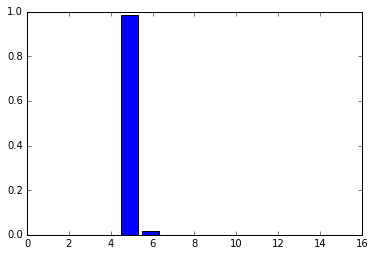

In [22]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(0.5, len(sc.nfamilies())+0.5), sc.nfamilies())

plt.show()

### Family size

We can also get the distribution of family sizes within the array, averaged over all partitions. This returns a vector of the same length as the number of offspring in the array. The $i^{th}$ element is the probability of observing a full sibship of size $i$.

In [23]:
sc.family_size()

array([  2.02168498e-001,   1.99457876e-001,   1.99457876e-001,
         2.02168500e-001,   1.96747249e-001,   2.44922565e-009,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         1.54752119e-074,   0.00000000e+000,   4.84960886e-111,
         0.00000000e+000,   0.00000000e+000,   8.45046145e-162])

Plotting this shows that we are roughly equally likely to observe a family of sizes one, two, three, four and five. 

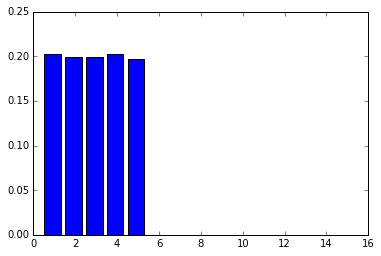

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(len(sires))+0.5, sc.family_size())

plt.show()

### Sibling relationships

Often we want to know who is related to whom. `sc.full_sib_matrix()` returns an $n*n$ matrix, where $n$ is the number of offspring. Each element describes the log probability that a pair of individuals are full siblings. If we plot this using a heatmap you can clearly see the five full sibships jump out as blocks of red (>90% probability of being full siblings) against a sea of blue (near zero probability of being full siblings).

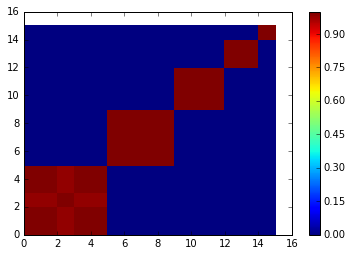

In [25]:
sibmat = sc.full_sib_matrix()
plt.pcolor(np.exp(sibmat))
plt.colorbar()
plt.show()